In [1]:
from __future__ import print_function
from __future__ import division

import sys
import os
qprc_path = os.path.abspath(os.path.join('..'))
if qprc_path not in sys.path:
    sys.path.append(qprc_path)
    
from utils.plots import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from  kernelfuzzy.fuzzyset import FuzzySet
from kernelfuzzy.fuzzysystem import get_rule_antecedents,plot_membership_fun
from  kernelfuzzy.fuzzification import FuzzyData, NonSingletonFuzzifier
from kernelfuzzy.kernels import gram_matrix_KBF_kernel,KBFkernel,NonSingletonKernel
from sklearn.datasets.samples_generator import make_classification
from sklearn.datasets import make_moons, make_circles,make_blobs,load_digits
from sklearn.svm import SVC,NuSVC
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from kernelfuzzy.kernels import nonsingleton_gaussian_kernel, gram_matrix_nonsingleton_gaussian_kernel
from sklearn.metrics import accuracy_score

# Training a Non-singleton Fuzzy System with SVM and KBF kernel

This notebook shows how to train a Nonsingleton fuzzy system using regularized kernel methods with the KBF kernel

## A dataset
We create a dataset and implement a C-SVM with RBF Gaussian kernel

           x1         x2  y
0    8.215974  -2.286723  0
1    5.429163  -9.280195  1
2    7.481698  -2.964036  0
3    7.933331  -3.515532  0
4    7.295732  -4.393924  0
5    5.730728  -2.608955  0
6    7.968331  -3.231253  0
7    6.703099  -9.593608  1
8    7.837622  -1.697561  0
9    7.694836  -2.633594  0
10   6.364965  -8.971899  1
11   9.242238  -3.880031  0
12   9.075684  -4.217905  0
13   7.117076  -8.204734  1
14   5.223231  -8.274415  1
15   8.210734  -4.003741  0
16   6.941477  -8.237210  1
17   6.541184  -9.848325  1
18   9.421693  -2.647699  0
19   5.979338  -9.308027  1
20   5.202007  -8.343255  1
21   8.075024  -4.259496  0
22   7.809966  -4.809444  0
23   8.033493  -2.265783  0
24   7.207213  -9.659486  1
25   6.364490  -9.734556  1
26   6.476133  -9.385655  1
27   8.714451  -2.417305  0
28   6.539507  -9.561072  1
29   6.838146  -9.539444  1
..        ...        ... ..
70   5.370422  -2.447152  0
71   7.887811  -3.657903  0
72   5.240166  -9.694241  1
73   8.491428  -2.54

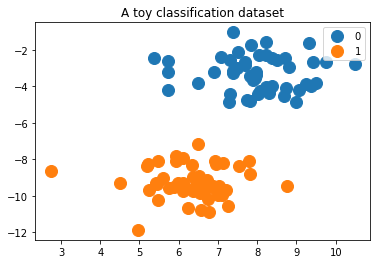

In [2]:
# we create 40 separable points
X, y = make_blobs(n_samples=100, centers=2, random_state=6)
X_test, y_test = make_blobs(n_samples=100, centers=2, random_state=6)
#X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)
#X_test, y_test = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)

#X, y = make_moons(noise=0.3, random_state=0)
#X_test, y_test = make_moons(noise=0.3, random_state=0)

#X, y = make_circles(noise=0.2, factor=0.5, random_state=1)
#X_test, y_test = make_circles(noise=0.2, factor=0.5, random_state=1)


df=pd.DataFrame(data=X,columns=['x1','x2'])
df['y']=y
print(df)

#plot the dataset
groups = df.groupby('y')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.x1, group.x2, marker='o', linestyle='', ms=12, label=name)
ax.legend()
plt.title("A toy classification dataset")
plt.show()


## A SVM solution with Gaussian kernel

support vector indices :[ 2  6 41 48 49 53 57 70 78 85 86 92 14 26 30 31 39 42 51 74 76 89 91 97]
number of support vector per class :[12 12]


//anaconda/envs/fuzzy-kernels/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



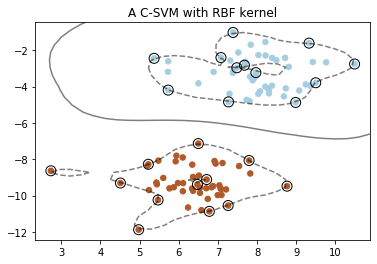

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SVM + Gaussian kernel + cross validation
Fitting 5 folds for each of 36 candidates, totalling 180 fits
best model:  SVC(C=0.125, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.125, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.3s finished


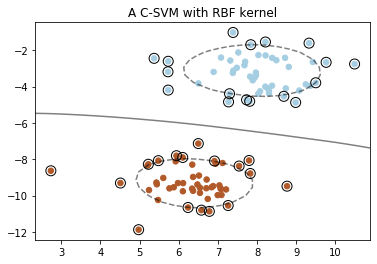

support vector indices :[ 4  5  8 22 41 44 48 49 52 65 67 70 78 84 85 86 92 14 31 36 39 50 51 54
 59 61 64 66 74 76 89 91 93 97]
number of support vector per class :[17 17]


In [3]:
# A C-SVM with Gaussian RBF kernel
clf = SVC(C=1000)
clf.fit(X, y)

print("support vector indices :{}".format(clf.support_))
print("number of support vector per class :{}".format(clf.n_support_))
plt.title("A C-SVM with RBF kernel")
plot_decision_function(X,y,clf,0)

# A C-SVM with Gaussian RBF kernel with cross-validation
#########################
print("SVM + Gaussian kernel + cross validation")
pipe = Pipeline([('svm', SVC())])

#grid search over KBF kernel parameter   
cv_params = dict([
    ('svm__gamma', 2.0**np.arange(-3,3)),
    ('svm__C', 2.0**np.arange(-3,3)),
])

model = GridSearchCV(pipe, cv_params, cv=5, verbose=1, n_jobs=1)
model.fit(X, y)
    
#training the model with the best parameters
print("best model: ", model.best_estimator_['svm'])
clf=model.best_estimator_['svm']
plt.title("A C-SVM with RBF kernel")
plot_decision_function(X,y,clf,0)
print("support vector indices :{}".format(clf.support_))
print("number of support vector per class :{}".format(clf.n_support_))


## Non-singleton fuzzification of the dataset
In this step we perform a nonsingleton fuzzification for each value in the dataset, e.g., in row 0, the value 6.37 is transformed into a Gaussian fuzzy set with μ=6.37 and σ value. :

Heuristic for estimation of the individual $\mu_{i,d}, \sigma_{i,d}, i=1,\dots, N, d=1,\dots, D$ values for each data point: 
* $\mu_{i,d} = x_{i,d}$
* $\sigma_{i,d}\sim \mathcal{N}(\rho, \theta_{d,c})$ 

We used:
* $\theta_{d,c}=5\%* std(d,c)$ ,i.e a percentage of the std of dimension $d$ and class $c$
* $\rho \sim \mathcal{U}[std(d,c)/10, std(d,c)/2]$


In [4]:
std_proportion=5.71
fuzzy_data=NonSingletonFuzzifier( std_proportion=std_proportion, constant_std=True ).transform(X,y)
#plot_fuzzydata(fuzzy_data,X)

## Training a Non-singleton FS with a C-SVM with KBF kernel


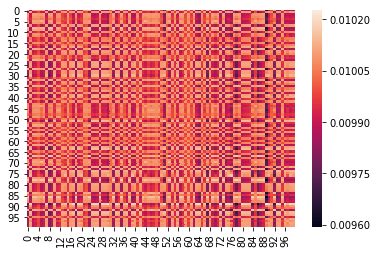

indices in training data that became rule-antecedents:[48 31]
number of rule-antecedents per class :[1 1]
dual coefficients : [[-35476.92191943  35476.92191943]]
SVC(C=524288.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='precomputed', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


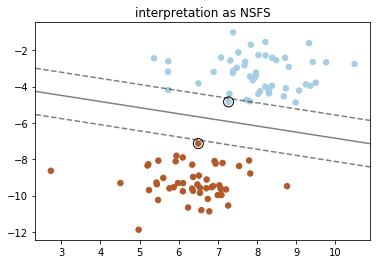

In [5]:
#{'svm__kernel': 'precomputed', 'svm__C': 524288.0, 'KBFkernel__param': 0.0625, 'Fuzzifier__std_proportion': 5.71}
#computing the kernel matrix
X_train = fuzzy_data
y_train = y

gamma=0.0625
K = gram_matrix_KBF_kernel(X_train, X_train, gamma)
sns.heatmap(K)
plt.show()

#training with a C-SVM
svc_p = SVC(kernel='precomputed',C=524288.0)
svc_p.fit(K,y_train)

print("indices in training data that became rule-antecedents:{}".format(svc_p.support_))
print("number of rule-antecedents per class :{}".format(svc_p.n_support_))
#print("support vectors class 0 :{}".format(clf.support_vectors_[:, 0]))
#print("support vectors class 1 :{}".format(clf.support_vectors_[:, 1]))
print("dual coefficients : {}".format(svc_p.dual_coef_))
print(svc_p)

plt.title("interpretation as NSFS")
plot_decision_function_kernel_KBF(X,  y, svc_p, std_proportion,gamma, type=0)


## Estimating the fuzzy rule-antecedents

Membership function Rule antecedents


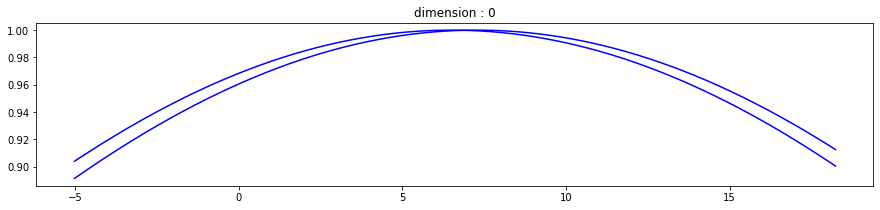

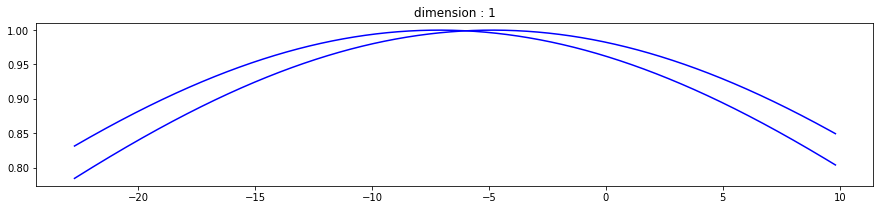

Membership function of fuzzy numbers linked to rule antecedents


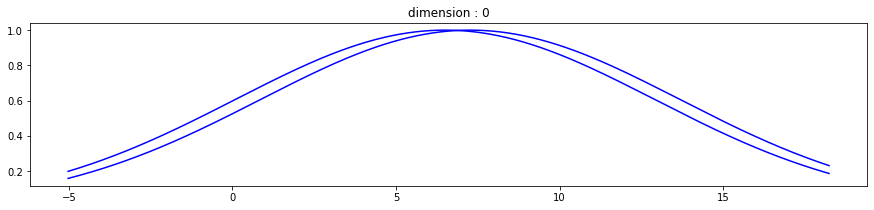

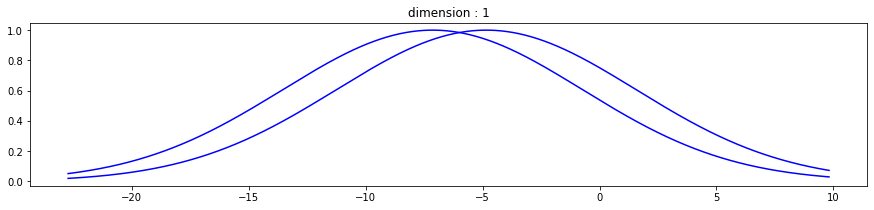

plot of vectors of fuzzy sets linked to rule antecedents


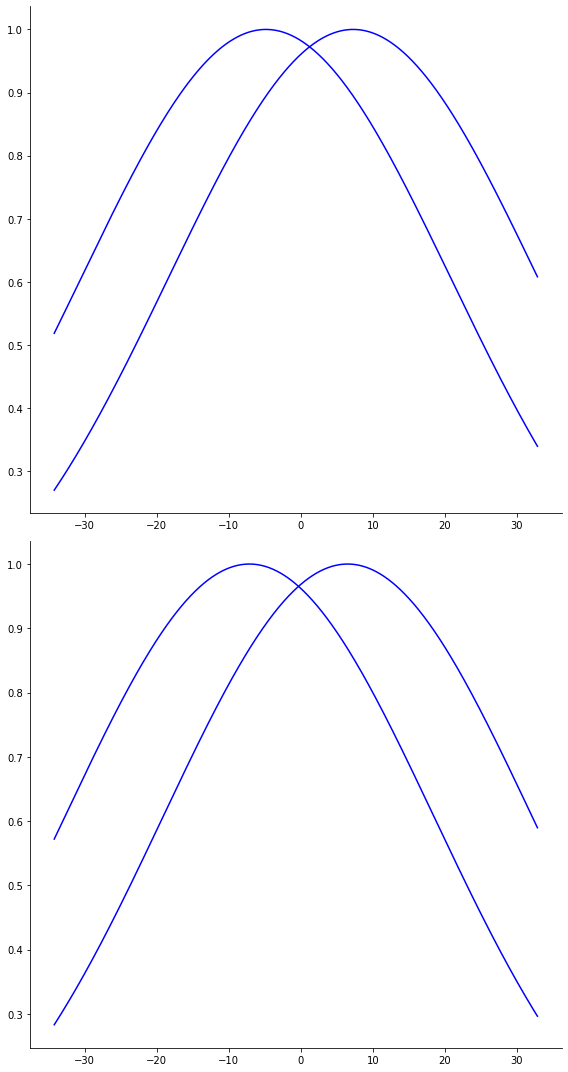

plot of vectors of fuzzy sets linked to the fuzzy numbers linked to rule antecedents


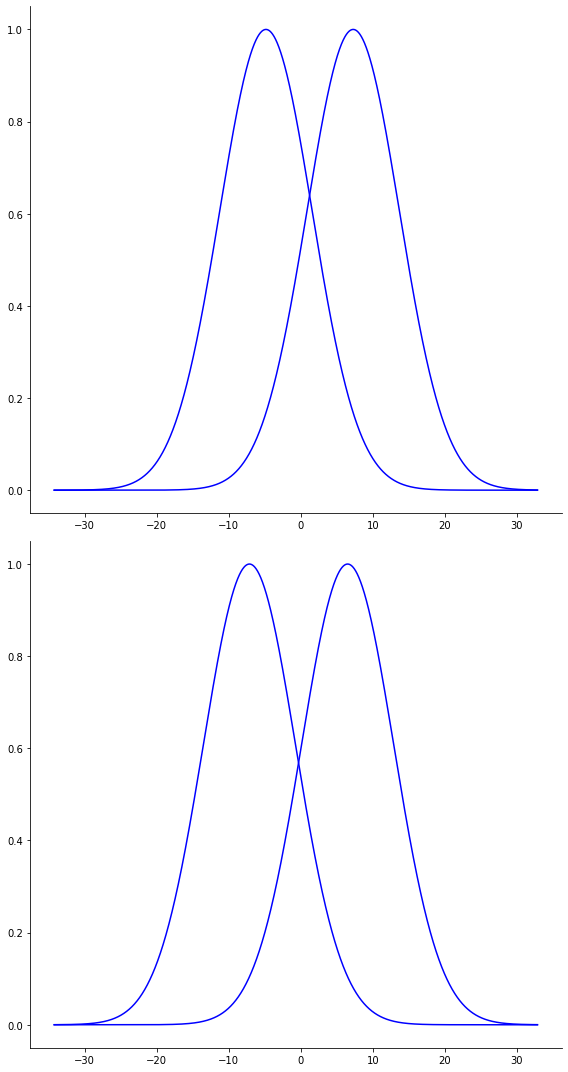

In [16]:
percentage_x_plot=100
clf=svc_p
rules_antecedents=get_rule_antecedents(clf, fuzzy_data, gamma)
print("Membership function Rule antecedents")
plot_membership_fun(rules_antecedents,X,percentage_x_plot)
print("Membership function of fuzzy numbers linked to rule antecedents")
plot_membership_fun(fuzzy_data[clf.support_,:],X,percentage_x_plot)

print("plot of vectors of fuzzy sets linked to rule antecedents")
plot_fuzzydata(rules_antecedents,X,percentage_x_plot)
print("plot of vectors of fuzzy sets linked to the fuzzy numbers linked to rule antecedents")
plot_fuzzydata(fuzzy_data[clf.support_,:],X,percentage_x_plot)

## Training a Non-singleton FS with a C-SVM with KBF kernel and  cross-validation

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.7s finished


{'svm__kernel': 'precomputed', 'svm__C': 16384.0, 'KBFkernel__param': 0.0625, 'Fuzzifier__std_proportion': 6.41}
best model:  Pipeline(memory=None,
         steps=[('Fuzzifier',
                 NonSingletonFuzzifier(constant_std=None, std_proportion=6.41)),
                ('KBFkernel', KBFkernel(param=0.0625)),
                ('svm',
                 SVC(C=16384.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='precomputed', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
best model:  SVC(C=16384.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='precomputed', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
[22 48 31 91]
[2 2]
[[-1

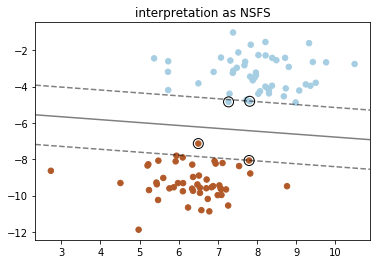

In [7]:
#pipe
#nuParam=0.1
pipe = Pipeline([
    ('Fuzzifier', NonSingletonFuzzifier(constant_std=True)),
    ('KBFkernel', KBFkernel()),
    ('svm', SVC())])

#grid search over KBF kernel parameter   
cv_params = dict([
    ('Fuzzifier__std_proportion',np.arange(0.01,np.std(X),0.1)),
    ('KBFkernel__param', 2.0**np.arange(-5,-3)),
    #('svm__C', np.arange(0.3,0.4,0.1)),
    ('svm__kernel', ['precomputed']),
    ('svm__C', 2.0**np.arange(-5,20)),
])

#model = GridSearchCV(pipe, cv_params, cv=5, verbose=1, n_jobs=-1)
model = RandomizedSearchCV(pipe, cv_params, cv=5, verbose=1, n_jobs=-1,n_iter=100)
model.fit(X, y)
    
#training the model with the best parameters
print(model.best_params_)
gamma=model.best_params_['KBFkernel__param']
std_proportion=model.best_params_['Fuzzifier__std_proportion']
clf=model.best_estimator_['svm']


print("best model: ", model.best_estimator_)
print("best model: ", model.best_estimator_['svm'])


print(clf.support_)
print(clf.n_support_)
print(clf.dual_coef_)
print(clf)

plt.title("interpretation as NSFS")
plot_decision_function_kernel_KBF(X,  y, clf, std_proportion,gamma, type=0)


Membership function Rule antecedents


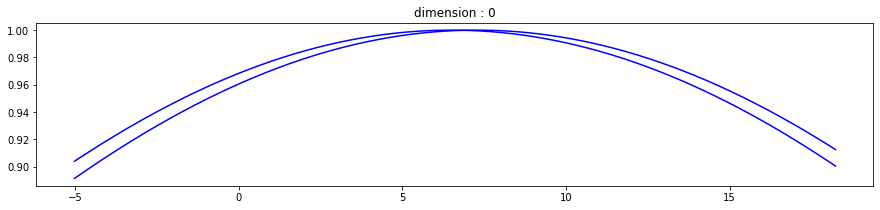

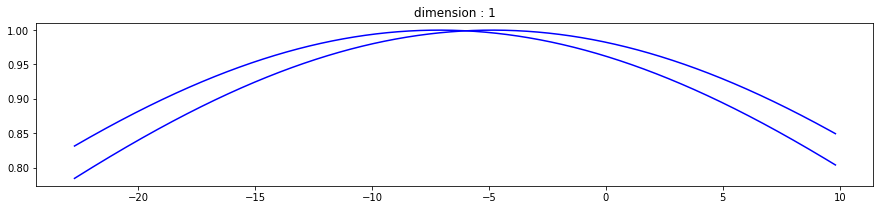

Membership function of fuzzy numbers linked to rule antecedents


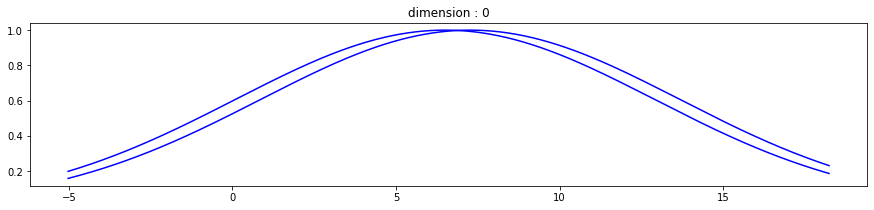

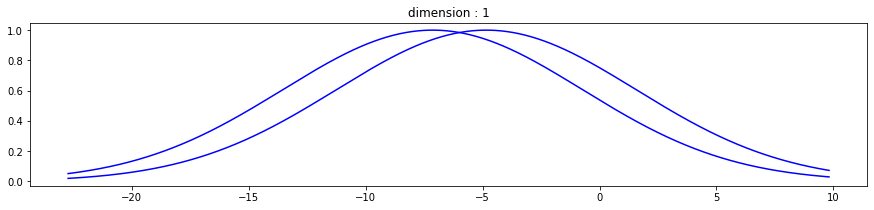

plot of vectors of fuzzy sets linked to rule antecedents


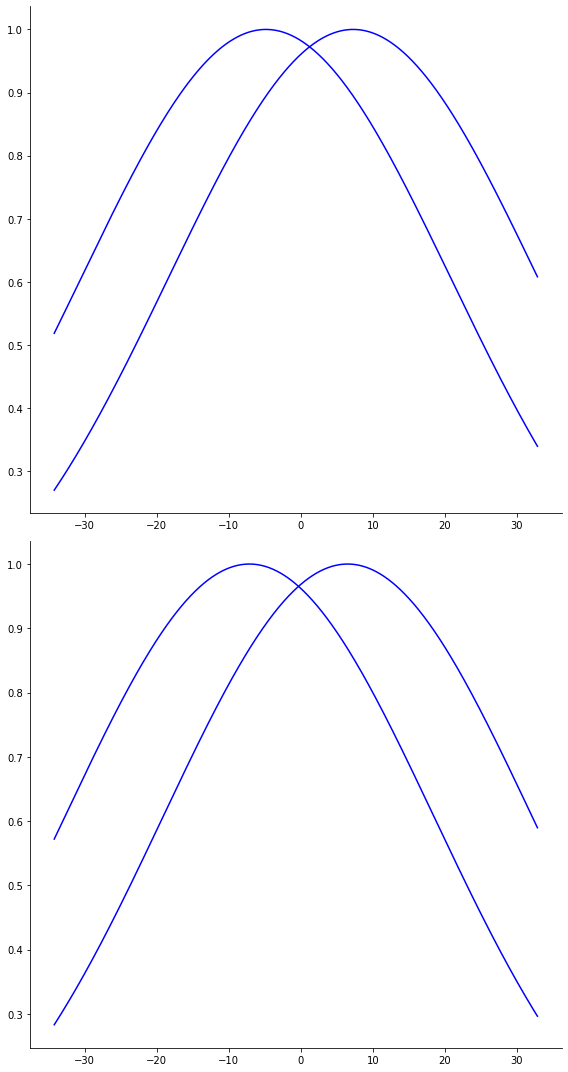

plot of vectors of fuzzy sets linked to the fuzzy numbers linked to rule antecedents


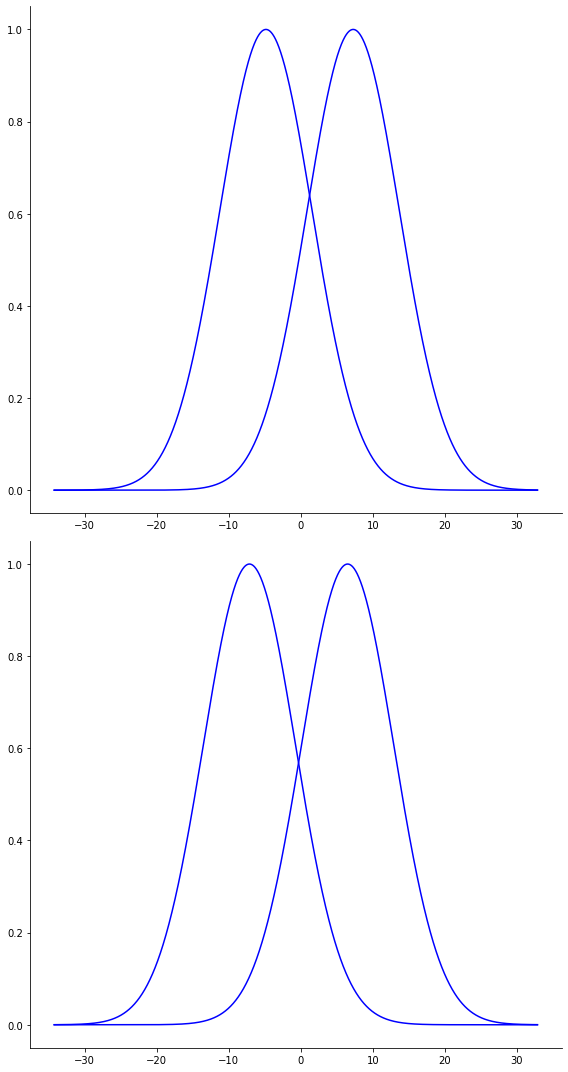

In [17]:
percentage_x_plot=100
fuzzy_data=NonSingletonFuzzifier( std_proportion=std_proportion, constant_std=True ).transform(X,y)
rules_antecedents=get_rule_antecedents(clf, fuzzy_data, gamma)
print("Membership function Rule antecedents")
plot_membership_fun(rules_antecedents,X,percentage_x_plot)
print("Membership function of fuzzy numbers linked to rule antecedents")
plot_membership_fun(fuzzy_data[clf.support_,:],X,percentage_x_plot)

print("plot of vectors of fuzzy sets linked to rule antecedents")
plot_fuzzydata(rules_antecedents,X,percentage_x_plot)
print("plot of vectors of fuzzy sets linked to the fuzzy numbers linked to rule antecedents")
plot_fuzzydata(fuzzy_data[clf.support_,:],X,percentage_x_plot)


## Construct the FBF expansion  and predict
For performing inference with the NSFS we estimate the FBF-expansion.

There are three equivalent approaches based on the nonsingleton fuzzy kernel
* fuzzify the training/test data with std estimated by cross-validation and construct the KBF kernel with gamma estimated from CV
* fuzzify the training/test data with std*sqrt(1/gamma), where gamma was estimated by cv, and estimate the KBF kernel with gamma=1
* fuzzified the test data with std*sqrt(1/gamma) and use the fuzzy rules, the FBF is then given by the KBF kernel with gamma =1

In [10]:
#APPROACH I, II, III ARE EQUIVALENT
############################
# approach 1:  not embedding the gamma
############################
#fuzzification
print("First approach")
fuzzy_data=NonSingletonFuzzifier( std_proportion=std_proportion, constant_std=True ).transform(X,y)
fuzzy_data_test=NonSingletonFuzzifier( std_proportion=std_proportion, constant_std=True ).transform(X_test,y_test)
#KBF/FBF expansion
K=gram_matrix_KBF_kernel(fuzzy_data_test,fuzzy_data, gamma) 
#print("kernel : {}", K)
ypred=(K[:,clf.support_]@clf.dual_coef_.T+clf.intercept_).flatten()
#print(ypred)
#print(sign_fun(ypred))
#print(clf.predict(K))
#print('diff',sign_fun(ypred)-clf.predict(K))
print("accuracy KBF/FBF", accuracy_score(y_test, clf.predict(K)))
print("accuracy KBF/FBF", accuracy_score(y_test, sign_fun(ypred)))

#######

############################
# approach 2: embedding the gamma
############################
print("Second approach")

#prediction with a FBF as KBF constructed using the nonsingleton kernel
#nonsingleton fuzzyfication
fuzzy_data_test=NonSingletonFuzzifier( std_proportion=std_proportion*np.sqrt(1/gamma), constant_std=True ).transform(X_test,y_test)
fuzzy_data=NonSingletonFuzzifier( std_proportion=std_proportion*np.sqrt(1/gamma), constant_std=True ).transform(X,y)
#FBF expansion
K=gram_matrix_KBF_kernel(fuzzy_data_test,fuzzy_data, 1) # gamma=1 because we actually embedded the gamma in the fuzzification and in the rules
#print("kernel : {}", K)
ypred=(K[:,clf.support_]@clf.dual_coef_.T+clf.intercept_).flatten()
#print(sign_fun(ypred))
print("accuracy KBF/FBF", accuracy_score(y_test, clf.predict(K)))
print("accuracy KBF/FBF", accuracy_score(y_test, sign_fun(ypred)))

#######

############################
# approach 3: embedding the gamma in the input and using the rules
############################
print("Third approach")

fuzzy_data_test=NonSingletonFuzzifier( std_proportion=std_proportion*np.sqrt(1/gamma), constant_std=True ).transform(X_test,y_test)
K=gram_matrix_KBF_kernel(fuzzy_data_test,rules_antecedents, 1) # gamma=1 because we actually embedded the gamma in the fuzzification and in the rules
# equivalent to: K=gram_matrix_KBF_kernel(fuzzy_data_test,fuzzy_data[clf.support_], 1) # gamma=1 because we actually embedded the gamma in the fuzzification and in the rules
#print("kernel : {}", K)
ypred=(K@clf.dual_coef_.T+clf.intercept_).flatten()
#print("accuracy KBF/FBF", accuracy_score(y_test, clf.predict(K)))
print("accuracy KBF/FBF", accuracy_score(y_test, sign_fun(ypred)))


############################
# prediction of a SVM and the non-singleton kernel
############################
print("SVM + nonsingleton kernel")
fuzzy_data=NonSingletonFuzzifier( std_proportion=std_proportion, constant_std=True ).transform(X,y)
fuzzy_data_test=NonSingletonFuzzifier( std_proportion=std_proportion, constant_std=True ).transform(X_test,y_test)
#KBF/FBF expansion
K=gram_matrix_nonsingleton_gaussian_kernel(fuzzy_data_test,fuzzy_data, gamma) 
print("accuracy SVM + non-singleton", accuracy_score(y_test, clf.predict(K)))  

#Prediction with model pipeline
print("model pipeline predict")
#print(model.predict(X_test))
print("accuracy nonsingleton pipeline", accuracy_score(y_test, model.predict(X_test)))


First approach
accuracy KBF/FBF 1.0
accuracy KBF/FBF 1.0
Second approach
accuracy KBF/FBF 1.0
accuracy KBF/FBF 1.0
Third approach
accuracy KBF/FBF 1.0
SVM + nonsingleton kernel
accuracy SVM + non-singleton 1.0
model pipeline predict
accuracy nonsingleton pipeline 1.0
